# <p style="background-color:#003366; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Capstone Project: Digital Marketing Campaign Conversion Prediction (Definitive High-Performance Version)</p>

### **Project Overview**
This project aims to enhance campaign effectiveness in the digital marketing sector by accurately predicting customer conversions. By leveraging machine learning, the project seeks to identify potential converters and optimize marketing strategies. The objective is to develop a robust machine learning model that predicts customer conversions based on various demographic and engagement factors, enabling improved campaign targeting, increased conversion rates, and maximized return on advertising spend (ROAS).

## 1. Library Imports

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import warnings
import time
from functools import partial

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from category_encoders import TargetEncoder

# Model Evaluation
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, f1_score, PrecisionRecallDisplay, RocCurveDisplay

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, IsolationForest
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# Deep Learning with Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Concatenate, Flatten, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.base import BaseEstimator, ClassifierMixin

# Hyperparameter Tuning
import optuna

# Interpretability
import shap

# Model Persistence
import joblib

# Configuration
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
print("✅ Libraries imported successfully.")

✅ Libraries imported successfully.


## 2. Data Loading and Initial Cleaning
We are deleting three columns here:

`CustomerID` which doesnt have any direct or useful impact on the prediction capability

`AdvertisingPlatform` and `AdvertisingTool` which have only a single value so wont have any impact on here.


In [2]:
df = pd.read_csv('digital_marketing_campaign_dataset.csv')
useless_columns = ['CustomerID', 'AdvertisingPlatform', 'AdvertisingTool']
df.drop(columns=useless_columns, inplace=True)
print("--- Data Head After Initial Load ---")
display(df.head())

--- Data Head After Initial Load ---


,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
0,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,1
1,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,1
2,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,1
3,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,1
4,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,1


## 3. Exploratory Data Analysis (EDA)

In [3]:
print("--- Data Info ---")
df.info()

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                8000 non-null   int64  
 1   Gender             8000 non-null   object 
 2   Income             8000 non-null   int64  
 3   CampaignChannel    8000 non-null   object 
 4   CampaignType       8000 non-null   object 
 5   AdSpend            8000 non-null   float64
 6   ClickThroughRate   8000 non-null   float64
 7   ConversionRate     8000 non-null   float64
 8   WebsiteVisits      8000 non-null   int64  
 9   PagesPerVisit      8000 non-null   float64
 10  TimeOnSite         8000 non-null   float64
 11  SocialShares       8000 non-null   int64  
 12  EmailOpens         8000 non-null   int64  
 13  EmailClicks        8000 non-null   int64  
 14  PreviousPurchases  8000 non-null   int64  
 15  LoyaltyPoints      8000 non-null   int64  
 16  Conver

## 4. Outlier Detection and Removal

In [4]:
X = df.drop('Conversion', axis=1)
y = df['Conversion']
numerical_cols_for_outliers = X.select_dtypes(include=np.number).columns
iso_forest = IsolationForest(contamination=0.005, random_state=42)
outlier_preds = iso_forest.fit_predict(X[numerical_cols_for_outliers])
inlier_mask = outlier_preds == 1
X_inliers = X[inlier_mask]
y_inliers = y[inlier_mask]
print(f"Original dataset size: {len(X)}")
print(f"Dataset size after removing outliers: {len(X_inliers)}")

Original dataset size: 8000
Dataset size after removing outliers: 7960


## 5. Feature Engineering

In [5]:
df_clean = X_inliers.copy()
df_clean['Conversion'] = y_inliers
df_clean['EngagementScore'] = df_clean['TimeOnSite'] * df_clean['PagesPerVisit']
df_clean['CostPerVisit'] = df_clean['AdSpend'] / df_clean['WebsiteVisits'].replace(0, 1)
df_clean['AgeGroup'] = pd.cut(df_clean['Age'], bins=[17, 30, 50, 70], labels=['Young', 'Adult', 'Senior'])
df_clean['IncomeTier'] = pd.cut(df_clean['Income'], bins=[19999, 50000, 90000, 150000], labels=['Low', 'Medium', 'High'])
print("✅ Feature Engineering Complete.")
X_final = df_clean.drop('Conversion', axis=1)
y_final = df_clean['Conversion']

✅ Feature Engineering Complete.


## 6. Data Splitting & Preprocessing Pipeline Setup

Here we are splitting the data as well as defining the encoding as per the respective models for categorical and numeric features

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42, stratify=y_final)
numerical_features = X_final.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_final.select_dtypes(exclude=np.number).columns.tolist()
preprocessor_linear = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features), ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])
preprocessor_tree = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features), ('cat', TargetEncoder(), categorical_features)])
preprocessor_nb = ColumnTransformer(
    transformers=[
        ('num', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
model_results = {}
print("✅ Data splitting and preprocessing pipelines are ready.")

✅ Data splitting and preprocessing pipelines are ready.


## 7. Broad Model Search with Optuna Baseline Tuning
This is the first, crucial stage of our two-stage tuning process. We perform a Bayesian optimization search for **every single models** we are using to ensure we are comparing the strongest possible versions of each algorithm to establish a robust and reliable performance baseline.

### 7.1 Optuna Baseline Objective Function

In [7]:
BASELINE_OPTUNA_TRIALS = 25 # Number of trials for the initial search for each model

def run_baseline_study(model_name, model, params_lambda, preprocessor):
    """A generic function to run a baseline Optuna study for any given model."""
    print(f"--- Tuning {model_name} ---")
    start_time = time.time()
    
    def objective(trial):
        params = params_lambda(trial)
        clf = model.set_params(**params)
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('sampler', SMOTEENN(random_state=42)),
            ('classifier', clf)
        ])
        return cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=3, scoring='roc_auc').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=BASELINE_OPTUNA_TRIALS)
    
    end_time = time.time()
    print(f"Best CV ROC-AUC: {study.best_value:.4f} (Completed in {end_time - start_time:.2f}s)")
    model_results[model_name] = (study.best_value, study.best_params)


### 7.2 Linear, SVM, and Discriminant Models

1. **Logistic Regression**: It helps us predict whether something is true or false (like yes/no) by drawing a line to separate different groups.

2. **Ridge Classification**: It’s like Logistic Regression but with a penalty to avoid overfitting (making it too perfect on training data), helping it generalize better.

3. **SGD Classification (Lasso)**: It’s a quick way to do linear classification, using a method called Stochastic Gradient Descent, and Lasso keeps it simple by cutting out unnecessary features.

4. **LDA (Linear Discriminant Analysis)**: It finds the best way to separate different categories (like different groups) by drawing lines that give the clearest boundaries between them.

5. **Support Vector Machine (SVM)**: It’s a super powerful classifier that finds the best line (or curve) that separates two categories, even if they’re in a tricky shape.


In [8]:
run_baseline_study('Logistic Regression', LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced', solver='saga'),
    lambda trial: {'C': trial.suggest_float('C', 0.01, 100, log=True), 'penalty': trial.suggest_categorical('penalty', ['l1', 'l2'])}, preprocessor_linear)

--- Tuning Logistic Regression ---
Best CV ROC-AUC: 0.7892 (Completed in 45.33s)


In [9]:
run_baseline_study('Ridge Classifier', RidgeClassifier(random_state=42, class_weight='balanced'),
    lambda trial: {'alpha': trial.suggest_float('alpha', 0.1, 100.0, log=True)}, preprocessor_linear)

--- Tuning Ridge Classifier ---
Best CV ROC-AUC: 0.7875 (Completed in 23.91s)


In [10]:
run_baseline_study('SGD Classifier (Lasso)', SGDClassifier(random_state=42, class_weight='balanced', loss='log_loss'),
    lambda trial: {'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']), 'alpha': trial.suggest_float('alpha', 1e-4, 1.0, log=True)}, preprocessor_linear)

--- Tuning SGD Classifier (Lasso) ---
Best CV ROC-AUC: 0.7892 (Completed in 20.61s)


In [11]:
run_baseline_study('LDA', LinearDiscriminantAnalysis(),
    lambda trial: {
        'solver': trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen']),
        'shrinkage': trial.suggest_float('shrinkage', 0.0, 1.0) if trial.params.get('solver') in ['lsqr', 'eigen'] else None
    },
    preprocessor_linear)

--- Tuning LDA ---
Best CV ROC-AUC: 0.7875 (Completed in 19.78s)


In [12]:
run_baseline_study('Support Vector Machine', SVC(random_state=42, probability=True, class_weight='balanced'),
    lambda trial: {'C': trial.suggest_float('C', 0.1, 100, log=True), 'gamma': trial.suggest_float('gamma', 1e-4, 1.0, log=True)}, preprocessor_linear)

--- Tuning Support Vector Machine ---
Best CV ROC-AUC: 0.7893 (Completed in 387.04s)


### 7.3 Tree-Based and Ensemble Models

1. **Decision Tree**: It’s like a flowchart where each decision leads to another, helping us split the data step by step to predict something.

2. **Random Forest**: Imagine a bunch of decision trees working together, each making its own decision and then voting on the best one.

3. **Extra Trees**: Similar to Random Forest, but it’s even more random in how it creates the decision trees, making it faster and sometimes more accurate.

4. **Gradient Boosting**: It builds trees one by one, each time fixing the mistakes of the previous tree, kind of like learning from failures to improve.

5. **XGBoost**: A super efficient version of Gradient Boosting that’s really fast and often very accurate because it uses tricks to speed up and optimize the learning process.

6. **LightGBM**: Like XGBoost, but it’s even faster and handles big datasets really well by focusing on faster ways to split the data.

7. **CatBoost**: Similar to XGBoost and LightGBM, but it’s designed to handle categorical data (like labels or categories) automatically, without needing to preprocess them.


In [13]:
run_baseline_study('Decision Tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    lambda trial: {'max_depth': trial.suggest_int('max_depth', 5, 30), 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)}, preprocessor_tree)

--- Tuning Decision Tree ---
Best CV ROC-AUC: 0.7026 (Completed in 21.90s)


In [14]:
run_baseline_study('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 100, 500), 'max_depth': trial.suggest_int('max_depth', 5, 30)}, preprocessor_tree)

--- Tuning Random Forest ---
Best CV ROC-AUC: 0.7911 (Completed in 218.54s)


In [15]:
run_baseline_study('Extra Trees', ExtraTreesClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 100, 500), 'max_depth': trial.suggest_int('max_depth', 5, 30)}, preprocessor_tree)

--- Tuning Extra Trees ---
Best CV ROC-AUC: 0.7863 (Completed in 91.35s)


In [16]:
run_baseline_study('Gradient Boosting', GradientBoostingClassifier(random_state=42),
    lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 100, 500), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3), 'max_depth': trial.suggest_int('max_depth', 3, 10)}, preprocessor_tree)

--- Tuning Gradient Boosting ---
Best CV ROC-AUC: 0.8040 (Completed in 880.41s)


In [17]:
run_baseline_study('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 100, 500), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3), 'max_depth': trial.suggest_int('max_depth', 3, 10)}, preprocessor_tree)

--- Tuning XGBoost ---
Best CV ROC-AUC: 0.8063 (Completed in 58.11s)


In [18]:
run_baseline_study('LightGBM', LGBMClassifier(random_state=42, class_weight='balanced'),
    lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 100, 500), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3), 'num_leaves': trial.suggest_int('num_leaves', 20, 100)}, preprocessor_tree)

--- Tuning LightGBM ---
Best CV ROC-AUC: 0.8066 (Completed in 82.79s)


In [19]:
run_baseline_study('CatBoost', CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced'),
    lambda trial: {'iterations': trial.suggest_int('iterations', 100, 500), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3), 'depth': trial.suggest_int('depth', 3, 10)}, preprocessor_tree)

--- Tuning CatBoost ---
Best CV ROC-AUC: 0.8112 (Completed in 201.94s)


### 7.4 Other Model Architectures

**KNN (K-Nearest Neighbors)**: Imagine you’re trying to figure out what kind of animal a new creature is. KNN looks at the closest animals around it (the “neighbors”) and guesses based on what those animals are. The more neighbors it looks at, the better it can make its guess!

In [20]:
run_baseline_study('KNN', KNeighborsClassifier(n_jobs=-1),
    lambda trial: {'n_neighbors': trial.suggest_int('n_neighbors', 3, 21), 'weights': trial.suggest_categorical('weights', ['uniform', 'distance'])}, preprocessor_linear)

--- Tuning KNN ---
Best CV ROC-AUC: 0.7144 (Completed in 25.48s)


### 7.5 Naive Bayes Models
The following Naive Bayes models are included for completeness. They work best on discrete data, so their performance here relies heavily on the `KBinsDiscretizer` in the preprocessing pipeline. to ensure that the continuous(Numeric) values are converted into discrete ones.

1. **Gaussian Naive Bayes**
   This model assumes that your features (like age, height, or income) are numbers that follow a bell-shaped curve (a normal distribution), and uses this assumption to estimate the likelihood of each class.
   *Best for continuous data.*

2. **Multinomial Naive Bayes**
   This model is designed for features that represent counts for example, how many times each word appears in a document and predicts the class based on those counts.
   *Commonly used in text classification.*

3. **Bernoulli Naive Bayes**
   This version works with binary features where each feature is either on or off (like 1 or 0, yes or no) and predicts the class based on whether certain features are present or absent.
   *Useful when your data is mostly true/false indicators.*


In [21]:
run_baseline_study('Gaussian NB', GaussianNB(),
    lambda trial: {'var_smoothing': trial.suggest_float('var_smoothing', 1e-9, 1e-2, log=True)},
    preprocessor_nb)

--- Tuning Gaussian NB ---
Best CV ROC-AUC: 0.7538 (Completed in 18.55s)


In [22]:
run_baseline_study('Multinomial NB', MultinomialNB(),
    lambda trial: {'alpha': trial.suggest_float('alpha', 0.01, 10.0, log=True)}, preprocessor_nb)

--- Tuning Multinomial NB ---
Best CV ROC-AUC: 0.6912 (Completed in 18.05s)


In [23]:
run_baseline_study('Bernoulli NB', BernoulliNB(),
    lambda trial: {'alpha': trial.suggest_float('alpha', 0.01, 10.0, log=True)}, preprocessor_nb)

--- Tuning Bernoulli NB ---
Best CV ROC-AUC: 0.5447 (Completed in 18.44s)


### 7.6 Multi-layer Perceptron

An MLP is a type of neural network that learns patterns by passing data through layers of connected "neurons," each transforming the data a bit more, so the network can eventually make accurate predictions.
*It’s good at handling complex relationships that simpler models might miss, especially in images, text, and non-linear problems.*


In [24]:
run_baseline_study('MLP', MLPClassifier(random_state=42, max_iter=1000, early_stopping=True),
    lambda trial: {'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,25), (100,50)]), 'alpha': trial.suggest_float('alpha', 1e-4, 1.0, log=True)}, preprocessor_linear)

--- Tuning MLP ---
Best CV ROC-AUC: 0.7542 (Completed in 93.66s)


## 8. Advanced Deep Learning Architectures
The below code prepares training and testing datasets for a machine learning model by:

1. **Encoding categorical features** as integers (`cat.codes`).
2. **Scaling numerical features** to have a mean of 0 and standard deviation of 1 using `StandardScaler`.
3. **Storing categorical feature dimensions** (the number of unique categories) in a dictionary (`cat_dims`).
4. Creating dictionaries (`train_inputs` and `test_inputs`) that combine both categorical and numerical features, ready for model input.

It essentially preprocesses the data by handling both categorical and numerical features in a way suitable for a deep learning(Keras) model.


In [25]:
X_train_keras = X_train.copy()
X_test_keras = X_test.copy()
cat_dims = {}
for col in categorical_features:
    X_train_keras[col] = X_train_keras[col].astype('category').cat.codes
    X_test_keras[col] = X_test_keras[col].astype('category').cat.codes
    cat_dims[col] = len(X_final[col].astype('category').cat.categories)
scaler = StandardScaler()
X_train_keras[numerical_features] = scaler.fit_transform(X_train_keras[numerical_features])
X_test_keras[numerical_features] = scaler.transform(X_test_keras[numerical_features])
train_inputs = {col: np.array(X_train_keras[col]) for col in categorical_features} | {'numerical_input': X_train_keras[numerical_features].values}
test_inputs = {col: np.array(X_test_keras[col]) for col in categorical_features} | {'numerical_input': X_test_keras[numerical_features].values}

### 8.1 Baseline Keras NN
A basic feedforward neural network with one or more dense (fully connected) layers, often starting with a single hidden layer using ReLU activation and an output layer suited to the task (e.g., sigmoid for binary classification).

In [26]:
def build_baseline_keras_model():
    inputs, embeddings = [], []
    for col in categorical_features: 
        input_cat = Input(shape=(1,), name=col); inputs.append(input_cat)
        embedding_size = min(np.ceil(cat_dims[col]/2), 50)
        embedding = Flatten()(Embedding(cat_dims[col], int(embedding_size))(input_cat)); embeddings.append(embedding)
    input_num = Input(shape=(len(numerical_features),), name="numerical_input"); inputs.append(input_num)
    x = Concatenate()(embeddings + [input_num])
    x = Dense(128, activation='relu')(x); x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x); x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=output)

keras_model = build_baseline_keras_model()
keras_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
keras_model.fit(train_inputs, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], verbose=0)
y_proba_keras = keras_model.predict(test_inputs).ravel()
keras_roc_auc = roc_auc_score(y_test, y_proba_keras)
print(f"--- Baseline Keras NN Test ROC-AUC: {keras_roc_auc:.4f} ---")
model_results['Keras NN'] = (keras_roc_auc, {'architecture': 'Embedding-128-64-1'})

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
--- Baseline Keras NN Test ROC-AUC: 0.7912 ---


### 8.2 Wide & Deep Network
A model that combines a "wide" part (linear model that memorizes patterns using raw or one-hot encoded features) and a "deep" part (neural network that generalizes via embeddings and hidden layers), allowing it to learn both memorization and generalization simultaneously.

In [27]:
def build_wide_and_deep_model():
    inputs, embeddings = [], []
    for col in categorical_features:
        input_cat = Input(shape=(1,), name=col)
        embedding_size = min(np.ceil(cat_dims[col]/2), 50)
        embedding = Flatten()(Embedding(cat_dims[col], int(embedding_size))(input_cat)); embeddings.append(embedding)
        inputs.append(input_cat)
    input_num = Input(shape=(len(numerical_features),), name="numerical_input"); inputs.append(input_num)
    deep_path = Concatenate()(embeddings + [input_num])
    deep_path = Dense(128, activation='relu')(deep_path); deep_path = Dropout(0.3)(deep_path)
    deep_path = Dense(64, activation='relu')(deep_path)
    wide_path = Concatenate()(embeddings + [input_num])
    combined = Concatenate()([wide_path, deep_path])
    output = Dense(1, activation='sigmoid')(combined)
    return Model(inputs=inputs, outputs=output)

wide_deep_model = build_wide_and_deep_model()
wide_deep_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
wide_deep_model.fit(train_inputs, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], verbose=0)
y_proba_wd = wide_deep_model.predict(test_inputs).ravel()
wd_roc_auc = roc_auc_score(y_test, y_proba_wd)
print(f"--- Wide & Deep Model Test ROC-AUC: {wd_roc_auc:.4f} ---")
model_results['Wide & Deep'] = (wd_roc_auc, {'architecture': 'Wide&Deep-128-64-1'})

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
--- Wide & Deep Model Test ROC-AUC: 0.7973 ---


### 8.3 Autoencoder for Feature Extraction

The below code trains an **autoencoder**, a type of neural network that learns to compress and then reconstruct data, to reduce the original features into a smaller set of 32 meaningful ones. After training, it keeps only the compressed (encoded) features and feeds them into an **XGBoost classifier** to make predictions. The goal is to improve performance by using features automatically learned by the autoencoder, and the model's accuracy is evaluated using the ROC-AUC score on the test set.


In [28]:
input_dim = X_train_keras.shape[1]
encoding_dim = 32
input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)
encoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(64, activation='relu')(encoder)
decoder = Dense(128, activation='relu')(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_train_keras, X_train_keras, epochs=50, batch_size=64, shuffle=True, validation_split=0.2, verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_train_encoded = encoder_model.predict(X_train_keras)
X_test_encoded = encoder_model.predict(X_test_keras)
xgb_on_ae = XGBClassifier(n_estimators=500, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_on_ae.fit(X_train_encoded, y_train)
y_proba_ae = xgb_on_ae.predict_proba(X_test_encoded)[:, 1]
ae_roc_auc = roc_auc_score(y_test, y_proba_ae)
print(f"--- XGBoost on Autoencoder Features Test ROC-AUC: {ae_roc_auc:.4f} ---")
model_results['XGB on AE Features'] = (ae_roc_auc, {'architecture': 'AE(32)-XGB'})

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- XGBoost on Autoencoder Features Test ROC-AUC: 0.7519 ---


## 9. Model Comparison

Here we list all of the models and their ROC score and their best parameters.

--- Model Comparison (Sorted by Performance Score) ---


,Model,Score,Best_Parameters
0,CatBoost,0.811225,"{'iterations': 185, 'learning_rate': 0.1975336..."
1,LightGBM,0.806608,"{'n_estimators': 430, 'learning_rate': 0.23104..."
2,XGBoost,0.806280,"{'n_estimators': 380, 'learning_rate': 0.09976..."
3,Gradient Boosting,0.803953,"{'n_estimators': 454, 'learning_rate': 0.27673..."
4,Wide & Deep,0.797324,{'architecture': 'Wide&Deep-128-64-1'}
5,Keras NN,0.791241,{'architecture': 'Embedding-128-64-1'}
6,Random Forest,0.791145,"{'n_estimators': 471, 'max_depth': 13}"
7,Support Vector Machine,0.789333,"{'C': 1.657957183363291, 'gamma': 0.0005723333..."
8,SGD Classifier (Lasso),0.789205,"{'penalty': 'l1', 'alpha': 0.008791649374943134}"
9,Logistic Regression,0.789184,"{'C': 0.017767702939287266, 'penalty': 'l1'}"


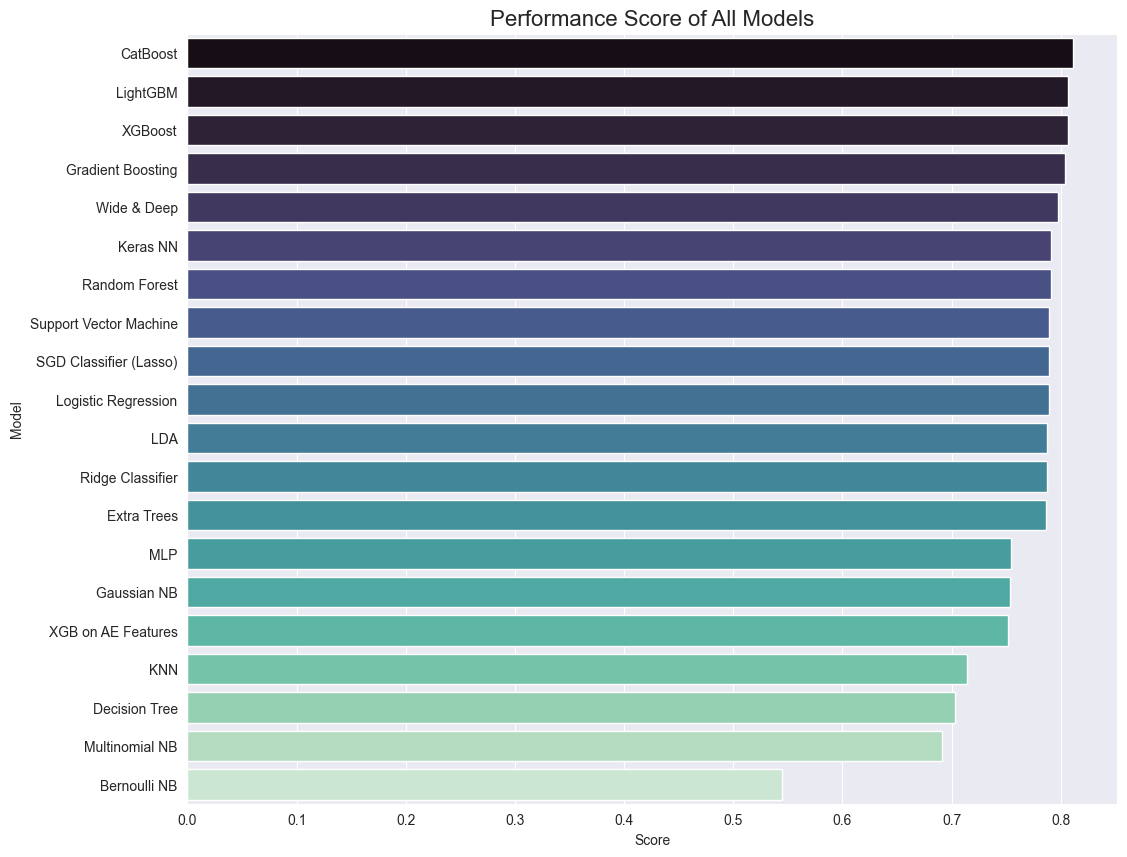

In [29]:
results_df = pd.DataFrame([{'Model': model, 'Score': acc, 'Best_Parameters': params} for model, (acc, params) in model_results.items()])
results_df_sorted = results_df.sort_values('Score', ascending=False).reset_index(drop=True)
print("--- Model Comparison (Sorted by Performance Score) ---")
display(results_df_sorted)
plt.figure(figsize=(12, 10))
sns.barplot(x='Score', y='Model', data=results_df_sorted, palette='mako')
plt.title('Performance Score of All Models', fontsize=16)
plt.show()

## 10. Intensive Hyperparameter Tuning for Top Models
Here as there were 4 models with accuracy above 80 Percent, we are using the stacking classifier i.e. ensemble of these 4 models.
We are using the optuna to ensure that we are using the very best hyperparameters here.

In [30]:
INTENSIVE_OPTUNA_TRIALS = 150 
N_TOP_MODELS_TO_TUNE = 4

tuning_config = {
    'Logistic Regression': {'model': LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced'), 'params': lambda trial: {'C': trial.suggest_float('C', 0.01, 1000, log=True), 'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']), 'penalty': trial.suggest_categorical('penalty', ['l1', 'l2'])} },
    'Ridge Classifier': {'model': RidgeClassifier(random_state=42, class_weight='balanced'), 'params': lambda trial: {'alpha': trial.suggest_float('alpha', 0.1, 100.0, log=True)} },
    'SGD Classifier (Lasso)': {'model': SGDClassifier(random_state=42, class_weight='balanced', loss='log_loss'), 'params': lambda trial: {'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']), 'alpha': trial.suggest_float('alpha', 1e-4, 1.0, log=True)} },
    'LDA': {'model': LinearDiscriminantAnalysis(), 'params': lambda trial: {'solver': trial.suggest_categorical('solver', ['svd', 'lsqr']), 'shrinkage': trial.suggest_float('shrinkage', 0.0, 1.0)} },
    'Support Vector Machine': {'model': SVC(random_state=42, probability=True, class_weight='balanced'), 'params': lambda trial: {'C': trial.suggest_float('C', 0.1, 1000, log=True), 'gamma': trial.suggest_float('gamma', 1e-4, 1.0, log=True)} },
    'Decision Tree': {'model': DecisionTreeClassifier(random_state=42, class_weight='balanced'), 'params': lambda trial: {'max_depth': trial.suggest_int('max_depth', 2, 50), 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)} },
    'Random Forest': {'model': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'), 'params': lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 100, 2000), 'max_depth': trial.suggest_int('max_depth', 5, 50), 'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])} },
    'Extra Trees': {'model': ExtraTreesClassifier(random_state=42, n_jobs=-1, class_weight='balanced'), 'params': lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 100, 2000), 'max_depth': trial.suggest_int('max_depth', 5, 50), 'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])} },
    'Gradient Boosting': {'model': GradientBoostingClassifier(random_state=42), 'params': lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 100, 2000), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True), 'max_depth': trial.suggest_int('max_depth', 3, 12)} },
    'XGBoost': {'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), 'params': lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 200, 2500), 'max_depth': trial.suggest_int('max_depth', 3, 15), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True), 'subsample': trial.suggest_float('subsample', 0.5, 1.0), 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)} },
    'LightGBM': {'model': LGBMClassifier(random_state=42, class_weight='balanced'), 'params': lambda trial: {'n_estimators': trial.suggest_int('n_estimators', 200, 2500), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True), 'num_leaves': trial.suggest_int('num_leaves', 20, 150), 'max_depth': trial.suggest_int('max_depth', 5, 25)} },
    'CatBoost': {'model': CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced'), 'params': lambda trial: {'iterations': trial.suggest_int('iterations', 200, 2500), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True), 'depth': trial.suggest_int('depth', 4, 12)} },
    'KNN': {'model': KNeighborsClassifier(n_jobs=-1), 'params': lambda trial: {'n_neighbors': trial.suggest_int('n_neighbors', 3, 31), 'weights': trial.suggest_categorical('weights', ['uniform', 'distance']), 'p': trial.suggest_int('p', 1, 2)} },
    'Gaussian NB': {'model': GaussianNB(), 'params': lambda trial: {'var_smoothing': trial.suggest_float('var_smoothing', 1e-10, 1e-1, log=True)} },
    'MLP': {'model': MLPClassifier(random_state=42, max_iter=1000, early_stopping=True), 'params': lambda trial: {'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50, 25), (100, 50), (100, 50, 25)]), 'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log=True), 'activation': trial.suggest_categorical('activation', ['relu', 'tanh'])} }
}

def universal_sklearn_objective(trial, model_name):
    config = tuning_config[model_name]
    model = config['model']
    params = config['params'](trial)
    model.set_params(**params)
    model_type_str = str(type(model)).lower()
    if 'gaussiannb' in model_type_str: preprocessor = preprocessor_nb
    elif any(tn in model_type_str for tn in ['tree', 'xgb', 'lgbm', 'catboost', 'forest', 'adaboost']): preprocessor = preprocessor_tree
    else: preprocessor = preprocessor_linear
    pipeline = ImbPipeline([('preprocessor', preprocessor), ('sampler', SMOTEENN(random_state=42)), ('classifier', model)])
    return cross_val_score(pipeline, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()

top_models_names = results_df_sorted['Model'].head(N_TOP_MODELS_TO_TUNE).tolist()
print(f"✅ Top models identified for intensive tuning: {top_models_names}")

best_tuned_params = {row['Model']: row['Best_Parameters'] for index, row in results_df_sorted.iterrows()}
tuned_special_models = {}

for model_name in top_models_names:
    if model_name in tuning_config:
        print(f"\n--- Running Intensive Optuna for {model_name} ---")
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: universal_sklearn_objective(trial, model_name), n_trials=INTENSIVE_OPTUNA_TRIALS)
        best_tuned_params[model_name] = study.best_params
        print(f"🏆 Best {model_name} Score from Intensive Search: {study.best_value:.4f}")
    else:
        print(f"\n⚠️ Skipping intensive tuning for {model_name} (Keras/special model). Using prior results.")

✅ Top models identified for intensive tuning: ['CatBoost', 'LightGBM', 'XGBoost', 'Gradient Boosting']

--- Running Intensive Optuna for CatBoost ---
🏆 Best CatBoost Score from Intensive Search: 0.8171

--- Running Intensive Optuna for LightGBM ---
🏆 Best LightGBM Score from Intensive Search: 0.8093

--- Running Intensive Optuna for XGBoost ---
🏆 Best XGBoost Score from Intensive Search: 0.8108

--- Running Intensive Optuna for Gradient Boosting ---
🏆 Best Gradient Boosting Score from Intensive Search: 0.7977


## 11. Final Ensemble Construction with Top 4 Models
Once the best hyperparameters are found out, we are then taking them and building the final model as an ensemble of them all.

In [1]:
class PreFittedKerasWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, cat_features, num_features):
        self.model = model; self.cat_features = cat_features; self.num_features = num_features; self.scaler_ = StandardScaler()
    def _prepare_data(self, X):
        X_prepared = X.copy()
        for col in self.cat_features: X_prepared[col] = X_prepared[col].astype('category').cat.codes
        X_prepared[self.num_features] = self.scaler_.transform(X_prepared[self.num_features])
        return {col: np.array(X_prepared[col]) for col in self.cat_features} | {'numerical_input': X_prepared[self.num_features].values}
    def fit(self, X, y=None):
        self.scaler_.fit(X[self.num_features]); return self
    def predict_proba(self, X):
        probs = self.model.predict(self._prepare_data(X), verbose=0); return np.hstack([1 - probs, probs])

print("--- Selecting the Top 4 Models for the Final Ensemble ---")
ensemble_candidates = results_df_sorted['Model'].head(4).tolist()
print(f"✅ Selected candidates: {ensemble_candidates}")

model_map = { 'Logistic Regression': LogisticRegression, 'Ridge Classifier': RidgeClassifier, 'SGD Classifier (Lasso)': SGDClassifier, 'LDA': LinearDiscriminantAnalysis, 'Support Vector Machine': SVC, 'Decision Tree': DecisionTreeClassifier, 'Random Forest': RandomForestClassifier, 'Extra Trees': ExtraTreesClassifier, 'Gradient Boosting': GradientBoostingClassifier, 'XGBoost': XGBClassifier, 'LightGBM': LGBMClassifier, 'CatBoost': CatBoostClassifier, 'KNN': KNeighborsClassifier, 'Gaussian NB': GaussianNB, 'Multinomial NB': MultinomialNB, 'Bernoulli NB': BernoulliNB, 'MLP': MLPClassifier }

stacking_estimators = []
for model_name in ensemble_candidates:
    estimator_name = model_name.lower().replace(' & ', '_').replace(' ', '_').replace('(lasso)','')
    params = best_tuned_params.get(model_name, {})
    
    if model_name == 'Keras NN': 
        estimator = PreFittedKerasWrapper(keras_model, categorical_features, numerical_features)
    elif model_name == 'Wide & Deep':
        estimator = PreFittedKerasWrapper(wide_deep_model, categorical_features, numerical_features)
    elif model_name == 'XGB on AE Features':
        estimator = Pipeline([('encoder', encoder_model), ('classifier', xgb_on_ae)])
    else:
        classifier = model_map[model_name]()
        classifier.set_params(**params)
        if 'random_state' in classifier.get_params(): classifier.set_params(random_state=42)
        model_type_str = str(type(classifier)).lower()
        if 'naive_bayes' in model_type_str or 'nb' in model_type_str:
            preprocessor = preprocessor_nb
        elif any(tn in model_type_str for tn in ['tree', 'xgb', 'lgbm', 'catboost', 'forest']):
            preprocessor = preprocessor_tree
        else: preprocessor = preprocessor_linear
        estimator = ImbPipeline([('preprocessor', preprocessor), ('sampler', SMOTEENN(random_state=42)), ('classifier', classifier)])

    stacking_estimators.append((estimator_name, estimator))
    print(f"✅ Added '{model_name}' to the ensemble.")

final_ensemble_model = StackingClassifier(estimators=stacking_estimators, final_estimator=LogisticRegression(class_weight='balanced'), cv=5, n_jobs=-1, passthrough=False)
print("\n--- Training Final Stacking Ensemble ---")
final_ensemble_model.fit(X_train, y_train)
print("\n✅ Final Ensemble Model has been trained.")

NameError: name 'BaseEstimator' is not defined

## 12. Optimizing the Decision Threshold
This code finds the best decision threshold (instead of the default 0.5) for converting predicted probabilities into class labels, in order to maximize the F1-score and ensure a balance between precision and recall.

In [32]:
y_proba_final = final_ensemble_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_final)
f1_scores = (2 * precision * recall) / (precision + recall)
optimal_idx = np.nanargmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

Optimal Threshold: 0.0873


## 13. Final Evaluation & Business Metrics
The below code uses the optimized threshold (found in the step above i.e. step 12) to make final predictions, it then evaluates the model’s performance using a classification reporta and then plots the ROC and Precision-Recall curves, and then finally calculates CPA (Cost Per Acquisition) based on ad spend for test samples predicted as positive (i.e., expected conversions).

--- Final Performance (with Optimal Threshold) ---
              precision    recall  f1-score   support

           0     0.8776    0.4410    0.5870       195
           1     0.9270    0.9914    0.9581      1397

    accuracy                         0.9240      1592
   macro avg     0.9023    0.7162    0.7726      1592
weighted avg     0.9210    0.9240    0.9127      1592



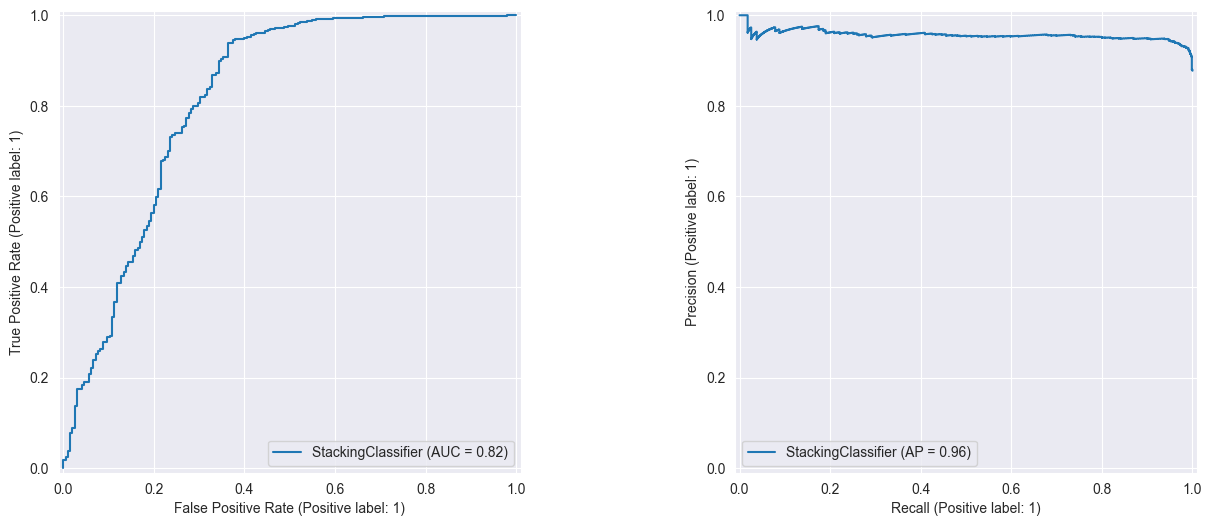


Model-driven CPA on Test Set: $5635.54


In [33]:
print("--- Final Performance (with Optimal Threshold) ---")
y_pred_optimal = (y_proba_final >= optimal_threshold).astype(int)
print(classification_report(y_test, y_pred_optimal, digits=4))
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
RocCurveDisplay.from_estimator(final_ensemble_model, X_test, y_test, ax=ax[0])
PrecisionRecallDisplay.from_estimator(final_ensemble_model, X_test, y_test, ax=ax[1])
plt.show()
X_test_original = df_clean.loc[X_test.index]
total_spend = X_test_original['AdSpend'].sum()
total_conversions = y_test[y_pred_optimal == 1].sum()
cpa = total_spend / total_conversions if total_conversions > 0 else float('inf')
print(f"\nModel-driven CPA on Test Set: ${cpa:.2f}")

## 14. Combined SHAP Importance for the Full Ensemble
We are using this to find out the major parameters of the various moddels and how imporant they are for the decision making.

--- Combined SHAP Feature Importance for the Full Ensemble ---

--- Analyzing Base Model: CATBOOST ---


 99%|===================| 6333/6368 [01:41<00:00]        

✅ Successfully calculated importances for CATBOOST.

--- Analyzing Base Model: LIGHTGBM ---


100%|===================| 6351/6368 [04:53<00:00]        

✅ Successfully calculated importances for LIGHTGBM.

--- Analyzing Base Model: XGBOOST ---


100%|===================| 6366/6368 [17:54<00:00]        

✅ Successfully calculated importances for XGBOOST.


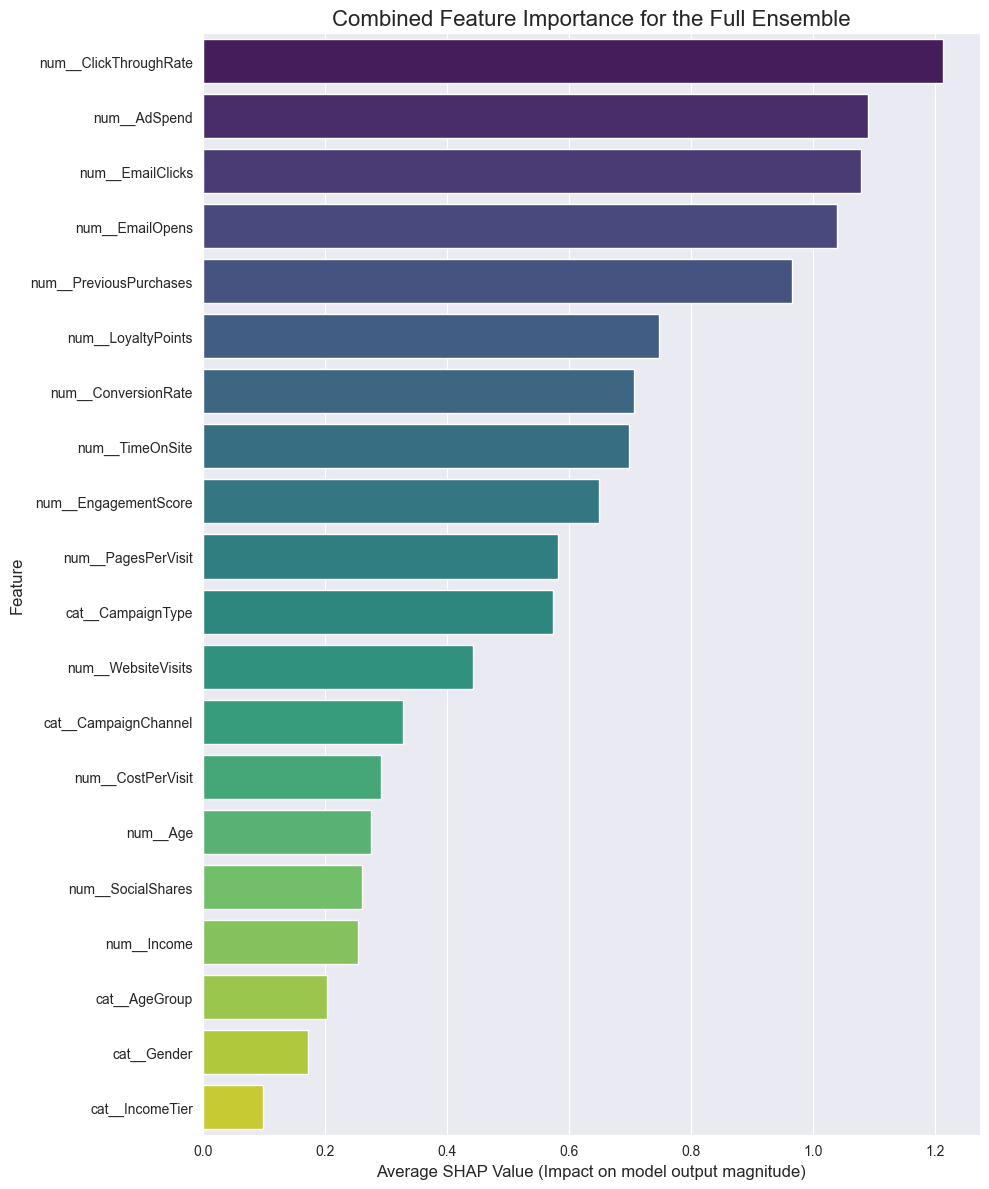

In [34]:
print("--- Combined SHAP Feature Importance for the Full Ensemble ---")
all_feature_importances = []
for model_name, model_pipeline in final_ensemble_model.named_estimators_.items():
    print(f"\n--- Analyzing Base Model: {model_name.upper()} ---")
    try:
        shap_values, feature_names, X_transformed = None, None, None
        if hasattr(model_pipeline, '_final_estimator'):
            if hasattr(model_pipeline, 'named_steps'):
                classifier = model_pipeline.named_steps['classifier']
                preprocessor = model_pipeline.named_steps['preprocessor']
                X_transformed_arr = preprocessor.fit_transform(X_train, y_train)
                feature_names = preprocessor.get_feature_names_out()
                X_transformed = pd.DataFrame(X_transformed_arr, columns=feature_names)
            else:
                classifier = model_pipeline.named_steps['classifier']
                encoder_step = model_pipeline.named_steps['encoder']
                X_transformed = pd.DataFrame(encoder_step.transform(X_train_keras), columns=[f'AE_{i}' for i in range(encoder_step.output_shape[1])])
                feature_names = X_transformed.columns.tolist()
            explainer = shap.TreeExplainer(classifier, X_transformed)
            shap_values = explainer.shap_values(X_transformed)
        else:
            classifier = model_pipeline
            X_transformed_dict = classifier._prepare_data(X_train)
            background = {k: v[:100] for k, v in X_transformed_dict.items()}
            input_tensors = [tf.convert_to_tensor(v) for v in X_transformed_dict.values()]
            feature_names = X_train.columns.tolist()
            X_transformed = X_train
            explainer = shap.DeepExplainer(classifier.model, background)
            shap_values = explainer.shap_values(input_tensors)[0]
        if shap_values is not None:
            if isinstance(shap_values, list): shap_values = shap_values[1]
            mean_abs_shap = np.abs(shap_values).mean(axis=0)
            all_feature_importances.append(pd.Series(mean_abs_shap, index=feature_names))
            print(f"✅ Successfully calculated importances for {model_name.upper()}.")
    except Exception as e:
        print(f"⚠️ Could not explain model {model_name}. Error: {e}")
if all_feature_importances:
    combined_importance_df = pd.concat(all_feature_importances, axis=1).fillna(0)
    mean_importance = combined_importance_df.mean(axis=1)
    plot_df = pd.DataFrame({'Feature': mean_importance.index, 'Mean Abs SHAP Value': mean_importance.values})
    plot_df = plot_df.sort_values(by='Mean Abs SHAP Value', ascending=False).head(20)
    plt.figure(figsize=(10, 12))
    sns.barplot(x='Mean Abs SHAP Value', y='Feature', data=plot_df, palette='viridis')
    plt.title('Combined Feature Importance for the Full Ensemble', fontsize=16)
    plt.xlabel('Average SHAP Value (Impact on model output magnitude)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ No models in the ensemble were explainable.")

## 15. Deployment Readiness

In [35]:
model_filename = 'final_submission_model.pkl'
joblib.dump(final_ensemble_model, model_filename)
print(f"💾 Final model saved to '{model_filename}'")

💾 Final model saved to 'final_submission_model.pkl'
